In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)
print("Files in the directory:")
for filename in os.listdir(path):
    if os.path.isfile(os.path.join(path, filename)):
        print(filename)

In [ ]:
import pandas as pd
# Load the data into a DataFrame
df_fake = pd.read_csv(os.path.join(path, "fake.csv"))
df_true = pd.read_csv(os.path.join(path, "true.csv"))
print("Shape of fake dataset:", df_fake.shape)
print("Shape of true dataset:", df_true.shape)

In [ ]:
combined_df = pd.concat([df_fake, df_true], ignore_index=True)

combined_df['is_bs'] = combined_df.apply(lambda row: 1 if row.name in df_fake.index else 0, axis=1)

print("Shape of combined dataset:", combined_df.shape)
combined_df.head(5)

In [ ]:
# This is a list of all the legitimate news articles that are not clearly labeled from Reuters. 
# This data will be removed from the training and testing dataset
unclean_negs = combined_df[(~combined_df['text'].str.contains('\(Reuters\) -', case=True) & (combined_df['is_bs'] == 0))]
print("Shape of unclean legitmate articles:", unclean_negs.shape)
unclean_negs.head(5)

### Clean the Dataset

In [ ]:
## Remove articles taht just quote tweets

mask = ~combined_df.index.isin(unclean_negs.index)

df_result = combined_df[mask]
df = df_result[['text', 'is_bs']]
print("Shape of final dataset:", df.shape)


In [27]:
df['text'] = df['text'].str.replace(r'^.*\(Reuters\)\s*-\s*', '', regex=True)

/var/folders/t7/7_zptf5x1vbbszvmqj98wzk80000gn/T/ipykernel_75221/4133627834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.replace(r'^.*\(Reuters\)\s*-\s*', '', regex=True)


### Remove Named Entities from Text

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

device = "mps" if torch.backends.mps.is_available() else "cpu"
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
ner = pipeline("ner", model=model, tokenizer=tokenizer, device=0 if device == "mps" else -1, grouped_entities=True)

def extract_entities(text):
    doc = ner(text)
    return [(ent['word'], ent['entity_group']) for ent in doc]

df['entities'] = df['text'].apply(extract_entities)


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0
/opt/homebrew/Caskroom/miniconda/base/envs/fake_news_classifier/lib/python3.11/site-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy

In [14]:
df.to_csv("../data/raw/processed_data.csv", index=False)

In [16]:
# Explode entity list
df_exploded = df.explode("entities")

# Split each tuple into two new columns
df_exploded[['entity', 'entity_group']] = pd.DataFrame(df_exploded['entities'].tolist(), index=df_exploded.index)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_k_entities(df, entity_group, k=10):
    df_filtered = df[df['entity_group'] == entity_group]

    top_bs = (
        df_filtered[df_filtered['is_bs'] == 1]
        .groupby('entity').size()
        .nlargest(k)
    )

    top_nonbs = (
        df_filtered[df_filtered['is_bs'] == 0]
        .groupby('entity').size()
        .nlargest(k)
    )

    # Merge for comparison (fill missing with 0s)
    merged = pd.concat([top_bs, top_nonbs], axis=1, keys=['is_bs=1', 'is_bs=0']).fillna(0)

    # Plotting
    merged.sort_values('is_bs=1', ascending=True).plot(kind='barh', figsize=(10, 6))
    plt.title(f"Top {k} Entities in {entity_group} (Fake vs Real)")
    plt.xlabel("Count")
    plt.ylabel("Entity")
    plt.tight_layout()
    plt.show()


In [20]:
df_exploded['entity_group'].unique()

array(['PER', 'MISC', 'LOC', 'ORG', None], dtype=object)

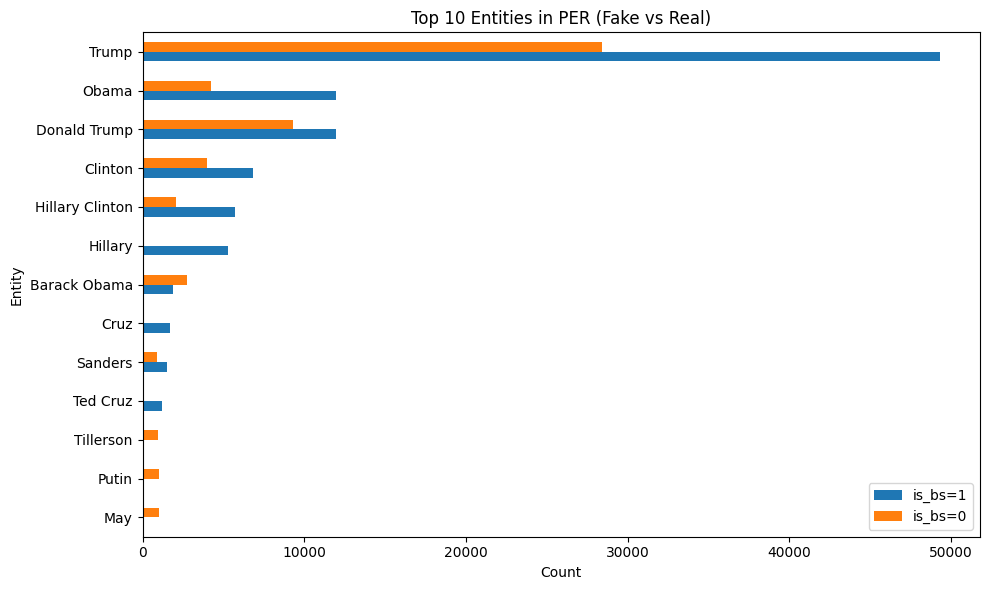

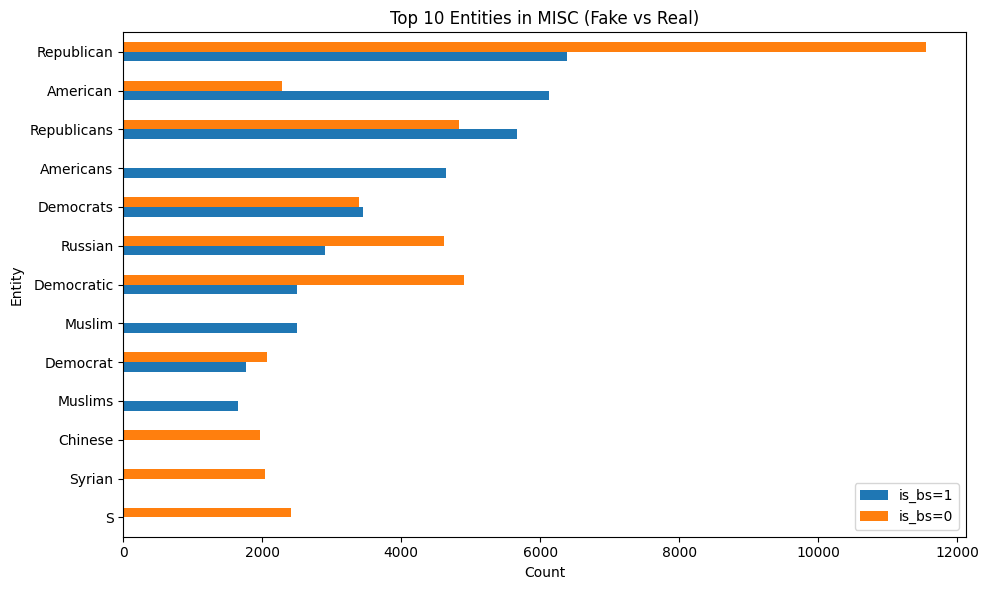

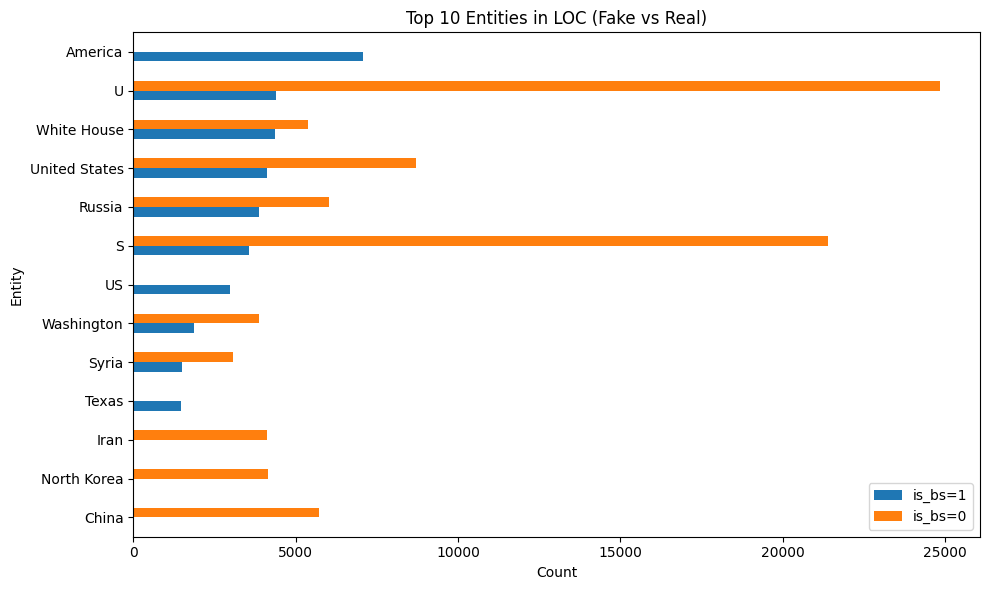

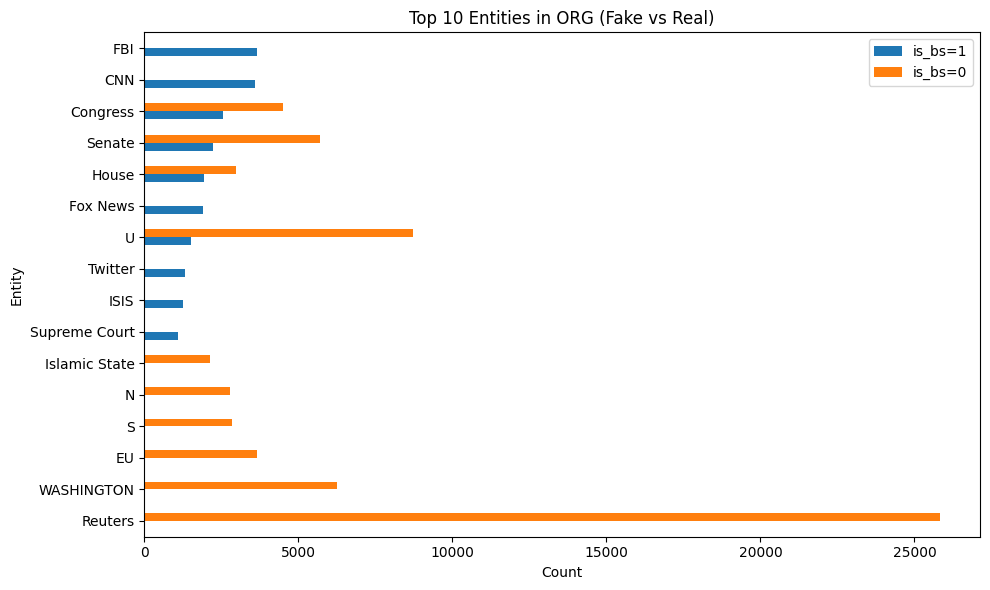

In [24]:
df_exploded = df_exploded[df_exploded['entity_group'].isin(['PER', 'MISC', 'LOC', 'ORG'])]
for eg in df_exploded['entity_group'].unique():
    plot_top_k_entities(df_exploded, eg, k=10)


### Mask Named Entities in the Data Set

In [29]:
import re
import random
import hashlib

def deterministic_seed(text):
    # Create a deterministic integer seed from the text using SHA256
    return int(hashlib.sha256(text.encode('utf-8')).hexdigest(), 16) % (10**8)

def mask_entities_per_row(text, entities):
    # Set a deterministic seed per row
    random.seed(deterministic_seed(text))

    mask_map = {}
    used_ids = set()
    
    # Replace longer entities first to avoid substring issues
    entities = sorted(entities, key=lambda x: -len(x[0]))

    for ent_text, ent_group in entities:
        if ent_text not in mask_map:
            # Generate a new random unused mask ID
            while True:
                mask_id = random.randint(1, 99999)
                if mask_id not in used_ids:
                    used_ids.add(mask_id)
                    break
            mask_token = f"<MASK_{mask_id}>"
            mask_map[ent_text] = mask_token

    # Replace all entity texts with their corresponding mask in the text
    for ent_text, mask_token in mask_map.items():
        pattern = re.compile(re.escape(ent_text))
        text = pattern.sub(mask_token, text)

    return text


In [30]:
df['masked_text'] = df.apply(lambda row: mask_entities_per_row(row['text'], row['entities']), axis=1)

df.to_csv("../data/raw/processed_data.csv", index=False)

/var/folders/t7/7_zptf5x1vbbszvmqj98wzk80000gn/T/ipykernel_75221/530878299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['masked_text'] = df.apply(lambda row: mask_entities_per_row(row['text'], row['entities']), axis=1)
